In [121]:
###Generate table for manipulation
#Import modules
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
from astropy.io import fits
import basic
import warnings
import math
%matplotlib inline

#Suppress iPython warnings
warnings.filterwarnings('ignore')

#Import list of exposures/CCDs
night = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\exposures.fits')

#Make empty fits table
tab = Table.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\2011\g11d302\pcat\g11d302.010.h5", path="1")
col1 = fits.Column(name='dr_g', format='D05', array=np.zeros(1))
col2 = fits.Column(name='dr_i', format='D05', array=np.zeros(1))
col3 = fits.Column(name='dr_z', format='D05', array=np.zeros(1))
col4 = fits.Column(name='dr_ddo51', format='D05', array=np.zeros(1))
col5 = fits.Column(name='tpm', format='D05', array=np.zeros(1))
coldefs = fits.ColDefs([col1, col2,col3,col4,col5])
dat = fits.BinTableHDU.from_columns(coldefs)
dat = Table.read(dat)
dat = dat[0:0]
tab = tab[0:0]
tab = hstack([dat,tab])

#Generate fits table with reddening-corrected photometry and total proper motion.  Cut not yet applied.
#Use 10 exposures
for i in range(60):
    #Load data using basic.py
    chip = int(night['ccdn'][i])
    u = Table.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(night['night'][i][1:3],night['night'][i][0:7],night['night'][i][0:14]), path="{0}".format(chip))
    t = basic.Catalog.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(night['night'][i][1:3],night['night'][i][0:7],night['night'][i][0:14]), chips=chip)

    #Correct for extinction
    g_extinct = t.extinction_correct('g')
    i_extinct = t.extinction_correct('i')
    z_extinct = t.extinction_correct('z')
    d_extinct = t.extinction_correct('ddo51')

    #Proper motions in RA and DEC
    pmra = u['pmra']
    pmde = u['pmde']

    #Calculate total proper motion
    tpm = np.sqrt(pmra**2+pmde**2)

    #Numpy arrays with de-reddened photometry and total proper motions
    g = np.array(g_extinct)
    i = np.array(i_extinct)
    z = np.array(z_extinct)
    d = np.array(d_extinct)
    tpm = np.array(tpm)

    #fits table to house photometry and total proper motions
    col1 = fits.Column(name='dr_g', format='D05', array=np.zeros(len(u)))
    col2 = fits.Column(name='dr_i', format='D05', array=np.zeros(len(u)))
    col3 = fits.Column(name='dr_z', format='D05', array=np.zeros(len(u)))
    col4 = fits.Column(name='dr_ddo51', format='D05', array=np.zeros(len(u)))
    col5 = fits.Column(name='tpm', format='D05', array=np.zeros(len(u)))
    coldefs = fits.ColDefs([col1, col2,col3,col4,col5])
    dat = fits.BinTableHDU.from_columns(coldefs)
    dat = Table.read(dat)

    #Insert reddening corrected photometry and total proper motions
    dat['dr_g'] = g
    dat['dr_i'] = i
    dat['dr_z'] = z
    dat['dr_ddo51'] = d
    dat['tpm'] = tpm

    temp = hstack([u,dat])
    tab = vstack([tab,temp])

#Remove nans from new catalog
ind, = np.where((~np.isnan(tab['dr_g']))&(~np.isnan(tab['dr_i']))&(~np.isnan(tab['dr_z']))&
           (~np.isnan(tab['dr_ddo51']))&(~np.isnan(tab['tpm'])))
tab = tab[ind]

In [97]:
def diagplot(tab,title):  
    #Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=3)

    #Subplot 1: g-DDO51 vs. g-i
    plt.subplot(1, 3, 1)

    #Pre-cut histogram
    xedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gd_xedge.npy')
    yedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gd_yedge.npy')
    retm3 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gd_counts.npy')
    retm3[retm3==0]=1
    plt.imshow(np.log(retm3.T),extent=[xedge.min(),xedge.max(),yedge.min(),yedge.max()],origin='lower', cmap='PuBu_r', aspect="auto")

    #Post-cut scatterplot    
    #Make subplots
    x = tab['dr_g'] - tab['dr_i']
    y = tab['dr_g'] - tab['dr_ddo51']
    plt.scatter(x,y,s=5,c='red',marker='*')
    plt.ylabel('g-DDO51')
    plt.xlabel('g-i')
    plt.xlim(-0.9,3.2)
    plt.ylim(-0.5,0.93)

    #Subplot 2: g-z vs. g-i
    plt.subplot(1, 3, 2)

    #Pre-cut histogram
    xedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gz_xedge.npy')
    yedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gz_yedge.npy')
    retm1 = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\gi_gz_counts.npy')
    retm1[retm1==0]=1
    plt.imshow(np.log(retm1.T),extent=[xedge.min(),xedge.max(),yedge.min(),yedge.max()],origin='lower', cmap='PuBu_r', aspect="auto")

    #Post-cut scatterplot
    x = tab['dr_g'] - tab['dr_i']
    y = tab['dr_g'] - tab['dr_z']
    plt.scatter(x,y,s=5,c='red',marker='*')
    plt.ylabel('g-z')
    plt.xlabel('g-i')
    plt.xlim(-1,2.7)
    plt.ylim(-2.3,3.6)

    #Subplot 3: tpm vs. g
    plt.subplot(1, 3, 3)

    #Pre-cut histogram
    xedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\g_tpm_xedge.npy')
    yedge = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\g_tpm_yedge.npy')
    retm = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\cut_diagnostics\g_tpm_counts.npy')
    retm[retm==0]=1
    ax = plt.imshow(np.log(retm.T),extent=[xedge.min(),xedge.max(),yedge.min(),yedge.max()],origin='lower', cmap='PuBu_r', aspect="auto")

    #Post-cut scatterplot
    x = tab['dr_g']
    y = tab['tpm']
    plt.scatter(x,y,s=5,c='red',marker='*')
    plt.ylabel('Total Proper Motion')
    plt.xlabel('g')
    plt.ylim(0,50)
    plt.xlim(14.3,20)

    #Colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
    fig.colorbar(ax, cax=cbar_ax)
    cbar_ax.set_ylabel('log(counts)', rotation=270, labelpad=+16)

    #Figure Title
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.8)

    fig.set_figheight(6)
    fig.set_figwidth(15)
    plt.show()

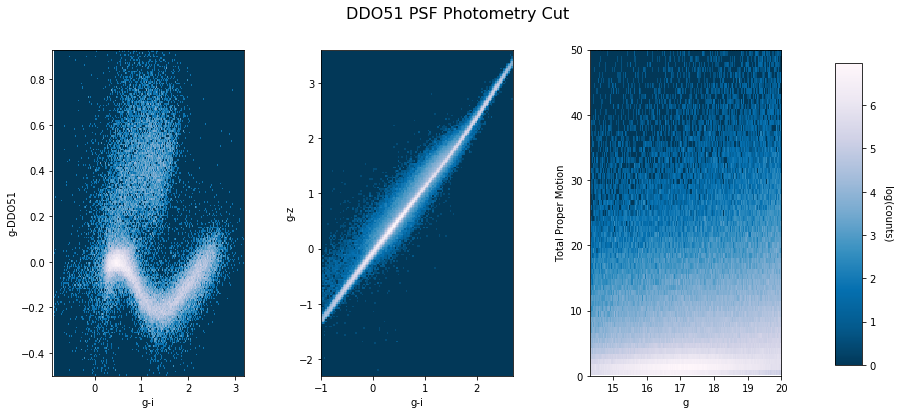

In [107]:
#CUT
ind, = np.where(~((tab['ddo51']<50)&(tab['ddo51']>1)))
tab1 = tab[ind]
diagplot(tab1,"DDO51 PSF Photometry Cut")

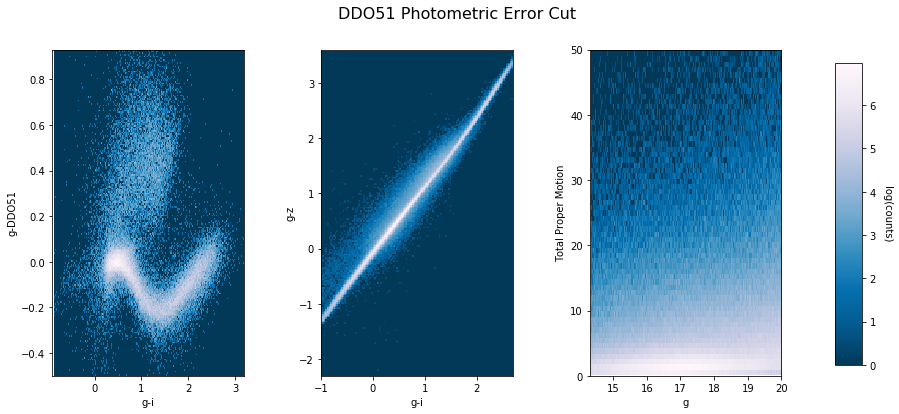

In [110]:
#CUT
ind, = np.where(~(tab['e_ddo51']<0.3))
tab1 = tab[ind]
diagplot(tab1,"DDO51 Photometric Error Cut")

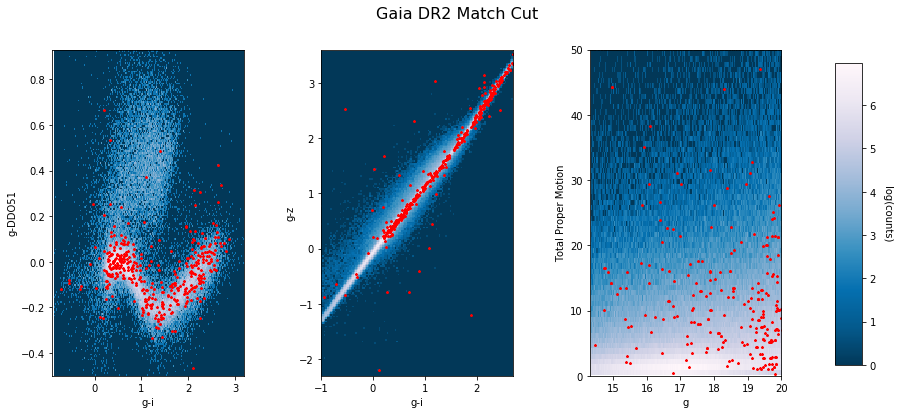

In [111]:
#CUT
ind, = np.where(~(tab['m_gaia']==2))
tab1 = tab[ind]
diagplot(tab1,"Gaia DR2 Match Cut")

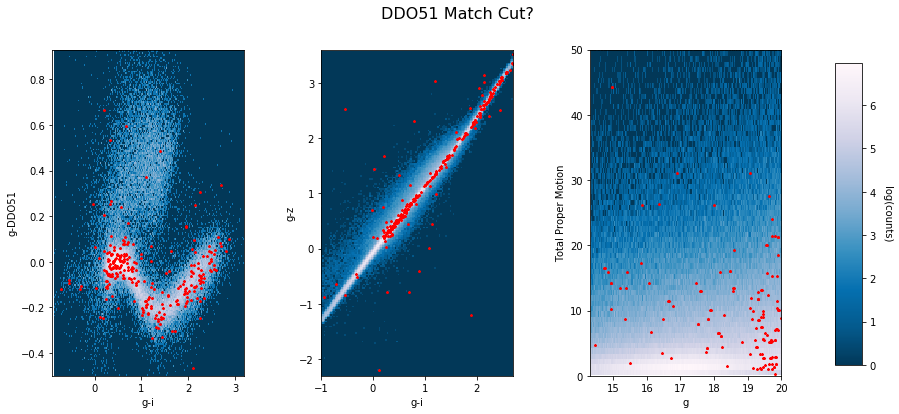

In [113]:
#CUT
ind, = np.where(~(tab['m_ddo51']==2))
tab1 = tab[ind]
diagplot(tab1,"DDO51 Match Cut?")

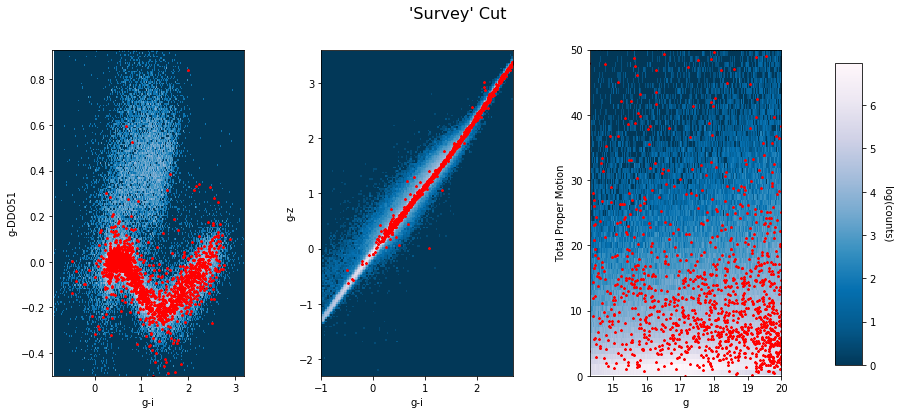

In [115]:
#CUT
ind, = np.where(~(tab['survey']==True))
tab1 = tab[ind]
diagplot(tab1,"'Survey' Cut")

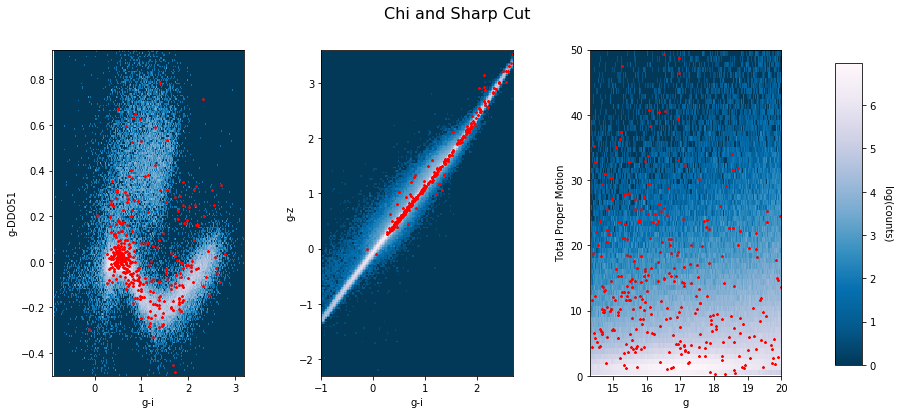

In [118]:
#CUT
ind, = np.where(~((tab['chi']<3)&(abs(tab['sharp'])<1)))
tab1 = tab[ind]
diagplot(tab1,"Chi and Sharp Cut")

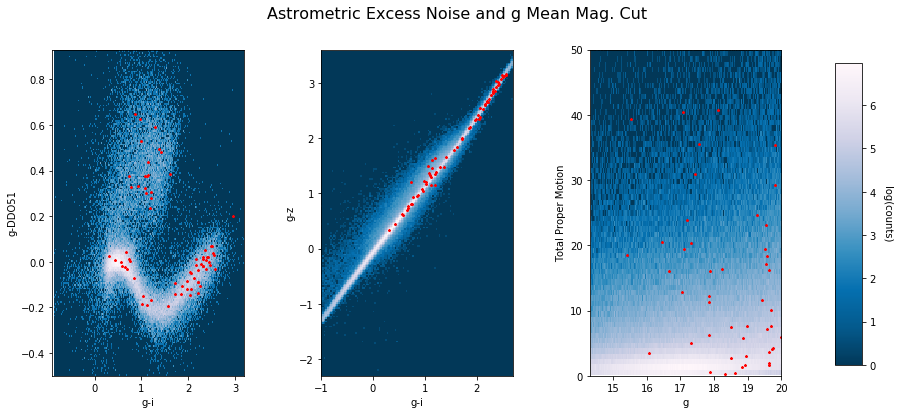

In [122]:
#CUT
ind, = np.where(~(((tab['astrometric_excess_noise']<3.1622)&(tab['phot_g_mean_mag']<=19)|(tab['phot_g_mean_mag']>19))&
               ((tab['astrometric_excess_noise']<(3.1622 + (10**1.25-10**0.5)/4*(tab['phot_g_mean_mag']-19)))&
               (tab['phot_g_mean_mag']>=19)|(tab['phot_g_mean_mag']<19))))
tab1 = tab[ind]
diagplot(tab1,"Astrometric Excess Noise and g Mean Mag. Cut")

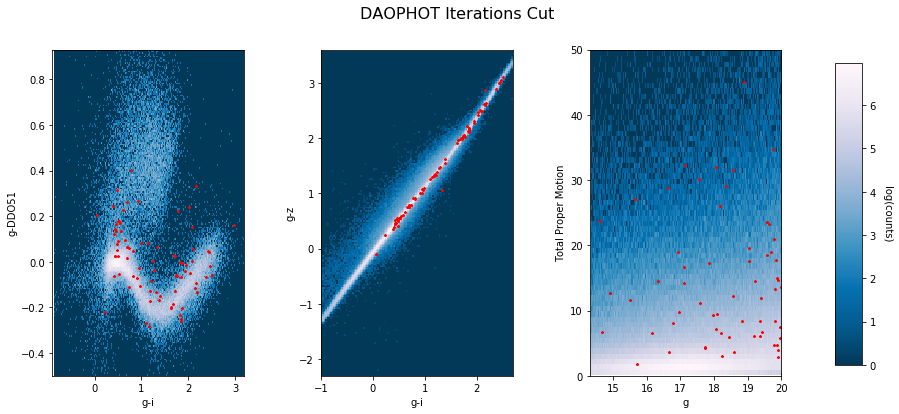

In [124]:
#CUT
ind, = np.where(~(tab['nIter']<10))
tab1 = tab[ind]
diagplot(tab1,"DAOPHOT Iterations Cut")

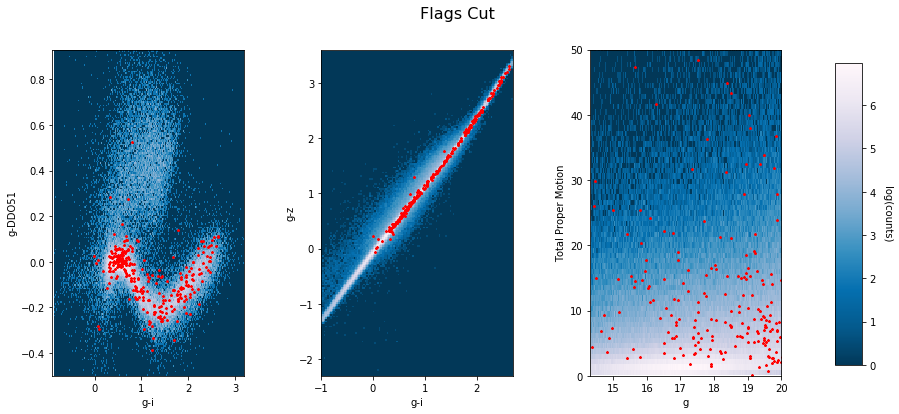

In [125]:
#CUT
ind, = np.where(((tab['FLAGS']==4)|(tab['FLAGS']==8)|(tab['FLAGS']==16)))
tab1 = tab[ind]
diagplot(tab1,"Flags Cut")

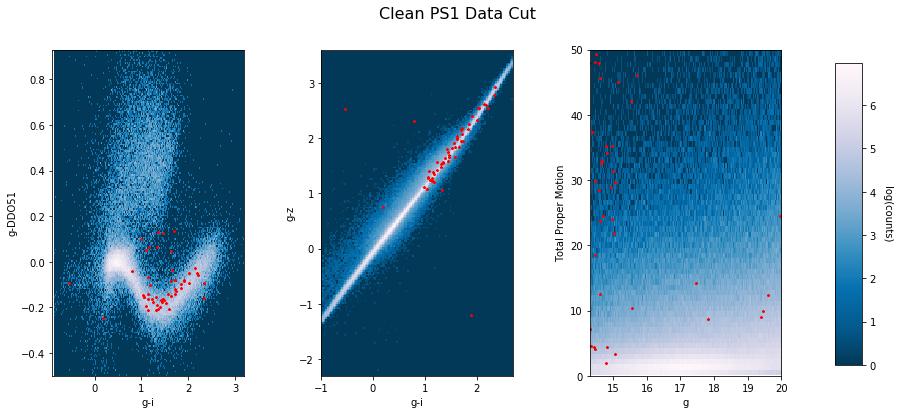

In [129]:
#CUT
ind, = np.where(((np.isnan(tab['i'])) | (np.isnan(tab['iKron'])))&~(((tab['i'] - tab['iKron']) < 0.05)&
               (tab['iNpt']>0)&
               (tab['iQfPerfect']>=0.85)&
               (tab['gNpt']>0)&
               (tab['gQfPerfect']>=0.85)&
               (tab['rNpt']>0)&
               (tab['rQfPerfect']>=0.85)))
tab1 = tab[ind]
diagplot(tab1,"Clean PS1 Data Cut")